Problem Setup:

A bandit problem involves multiple arms, each associated with a probability distribution of rewards. In a nonstationary bandit, the reward distribution for each arm changes over time.
Goal: Develop a strategy that adapts to these changes to maximize cumulative reward.

### Define a Time-Varying Reward Function:

- Each arm has a time-varying reward function. 
- One common approach is to use a Gaussian distribution whose mean drifts over time.
- mean_change_rate controls how fast the reward distribution changes.

In [2]:
import numpy as np

class NonStationaryBandit:
    def __init__(self, n_arms, mean_change_rate):
        self.n_arms = n_arms
        self.means = np.random.normal(0, 1, n_arms)
        self.mean_change_rate = mean_change_rate

    def get_reward(self, arm):
        # Simulate drift in means
        self.means += np.random.normal(0, self.mean_change_rate, self.n_arms)
        return np.random.normal(self.means[arm], 1)


- Exploration-Exploitation Strategy

In [3]:
class EpsilonGreedy:
    def __init__(self, n_arms, epsilon):
        self.n_arms = n_arms
        self.epsilon = epsilon
        self.q_values = np.zeros(n_arms)  # Estimate of the value of each arm
        self.arm_counts = np.zeros(n_arms)  # Count how often each arm is selected

    def select_arm(self):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.n_arms)
        else:
            return np.argmax(self.q_values)

    def update(self, arm, reward):
        self.arm_counts[arm] += 1
        # Incremental update of Q-values
        n = self.arm_counts[arm]
        self.q_values[arm] += (1 / n) * (reward - self.q_values[arm])


In [4]:
class SlidingWindowEpsilonGreedy(EpsilonGreedy):
    def __init__(self, n_arms, epsilon, window_size):
        super().__init__(n_arms, epsilon)
        self.window_size = window_size
        self.rewards = [[] for _ in range(n_arms)]

    def update(self, arm, reward):
        # Append reward to the sliding window for the selected arm
        self.rewards[arm].append(reward)
        if len(self.rewards[arm]) > self.window_size:
            self.rewards[arm].pop(0)
        # Update the Q-value based on the sliding window
        self.q_values[arm] = np.mean(self.rewards[arm]) if self.rewards[arm] else 0


In [5]:
def run_simulation(bandit, strategy, n_steps):
    rewards = []
    chosen_arms = []

    for t in range(n_steps):
        arm = strategy.select_arm()
        reward = bandit.get_reward(arm)
        strategy.update(arm, reward)

        rewards.append(reward)
        chosen_arms.append(arm)

    return rewards, chosen_arms

# Define parameters
n_arms = 10
mean_change_rate = 0.1
epsilon = 0.1
window_size = 50
n_steps = 1000

# Create bandit and strategy
bandit = NonStationaryBandit(n_arms, mean_change_rate)
strategy = SlidingWindowEpsilonGreedy(n_arms, epsilon, window_size)

# Run simulation
rewards, chosen_arms = run_simulation(bandit, strategy, n_steps)


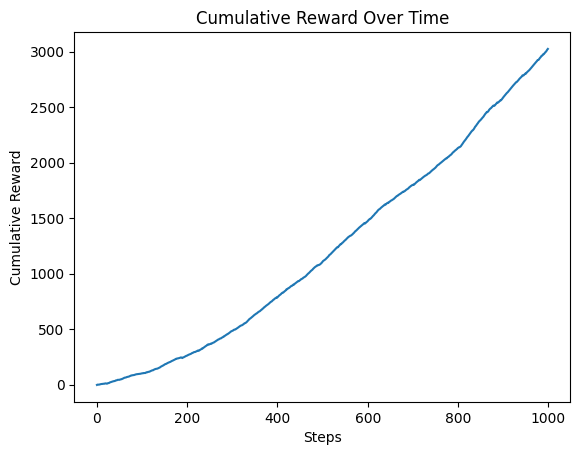

In [6]:
import matplotlib.pyplot as plt

# Plot cumulative rewards
cumulative_rewards = np.cumsum(rewards)
plt.plot(cumulative_rewards)
plt.title("Cumulative Reward Over Time")
plt.xlabel("Steps")
plt.ylabel("Cumulative Reward")
plt.show()


- Time-varying reward function: This models the nonstationarity aspect by letting the reward distribution change over time.
- Epsilon-greedy strategy: Balances exploration and exploitation, and with a sliding window, we ensure it adapts to recent changes in rewards.
- Sliding window: Allows the agent to forget older rewards and react quickly to changes, which is critical for nonstationary problems.

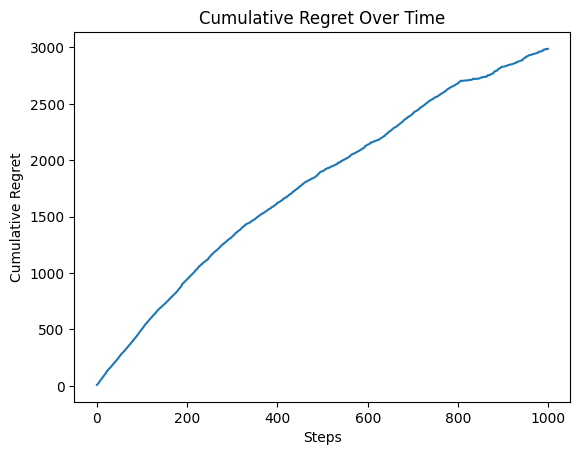

In [7]:
def calculate_regret(bandit, chosen_arms):
    optimal_rewards = []
    for t in range(len(chosen_arms)):
        optimal_reward = np.max(bandit.means)  # Best possible reward at each step
        optimal_rewards.append(optimal_reward)
    return np.cumsum(optimal_rewards) - np.cumsum(rewards)

regret = calculate_regret(bandit, chosen_arms)

# Plot cumulative regret
plt.plot(regret)
plt.title("Cumulative Regret Over Time")
plt.xlabel("Steps")
plt.ylabel("Cumulative Regret")
plt.show()


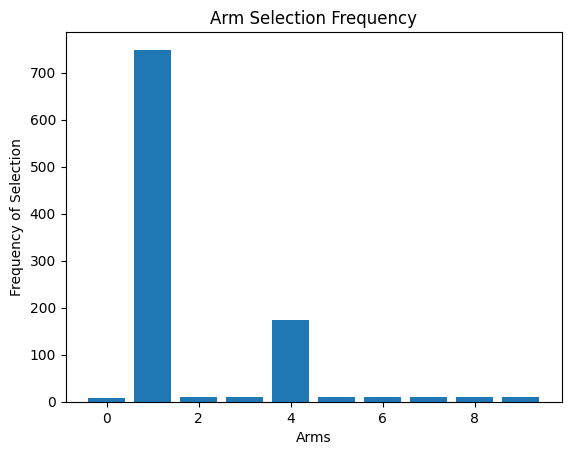

In [8]:
def plot_arm_selection_frequency(chosen_arms, n_arms):
    arm_counts = np.bincount(chosen_arms, minlength=n_arms)
    plt.bar(range(n_arms), arm_counts)
    plt.title("Arm Selection Frequency")
    plt.xlabel("Arms")
    plt.ylabel("Frequency of Selection")
    plt.show()

plot_arm_selection_frequency(chosen_arms, n_arms)


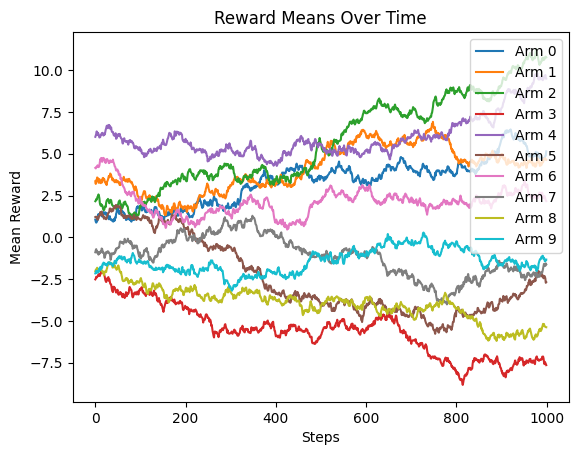

In [9]:
def plot_reward_means_over_time(bandit, n_steps):
    means_over_time = []
    for t in range(n_steps):
        means_over_time.append(bandit.means.copy())
        bandit.get_reward(0)  # Update the means

    means_over_time = np.array(means_over_time)
    for arm in range(n_arms):
        plt.plot(means_over_time[:, arm], label=f"Arm {arm}")

    plt.title("Reward Means Over Time")
    plt.xlabel("Steps")
    plt.ylabel("Mean Reward")
    plt.legend()
    plt.show()

plot_reward_means_over_time(bandit, n_steps)


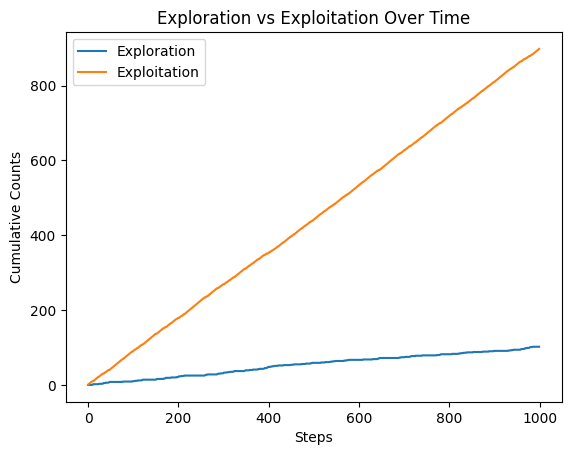

In [10]:
def plot_exploration_exploitation_ratio(strategy, n_steps):
    exploration_count = np.zeros(n_steps)
    exploitation_count = np.zeros(n_steps)

    for t in range(n_steps):
        if np.random.rand() < strategy.epsilon:
            exploration_count[t] += 1
        else:
            exploitation_count[t] += 1

    plt.plot(np.cumsum(exploration_count), label="Exploration")
    plt.plot(np.cumsum(exploitation_count), label="Exploitation")
    plt.title("Exploration vs Exploitation Over Time")
    plt.xlabel("Steps")
    plt.ylabel("Cumulative Counts")
    plt.legend()
    plt.show()

plot_exploration_exploitation_ratio(strategy, n_steps)


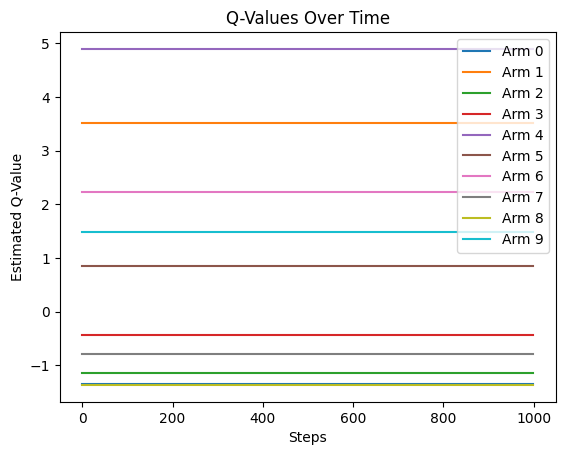

In [11]:
def plot_q_values(strategy, n_steps):
    q_values_over_time = np.zeros((n_steps, n_arms))

    for t in range(n_steps):
        q_values_over_time[t] = strategy.q_values.copy()
        strategy.select_arm()  # This simulates updating q-values over time

    for arm in range(n_arms):
        plt.plot(q_values_over_time[:, arm], label=f"Arm {arm}")

    plt.title("Q-Values Over Time")
    plt.xlabel("Steps")
    plt.ylabel("Estimated Q-Value")
    plt.legend()
    plt.show()

plot_q_values(strategy, n_steps)


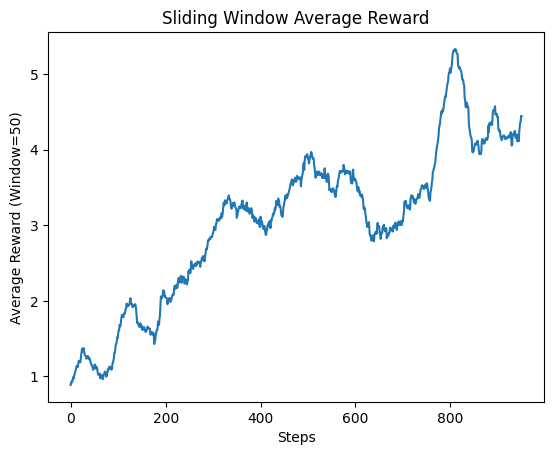

In [12]:
def plot_sliding_window_rewards(rewards, window_size):
    sliding_avg_reward = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
    plt.plot(sliding_avg_reward)
    plt.title("Sliding Window Average Reward")
    plt.xlabel("Steps")
    plt.ylabel(f"Average Reward (Window={window_size})")
    plt.show()

plot_sliding_window_rewards(rewards, window_size)


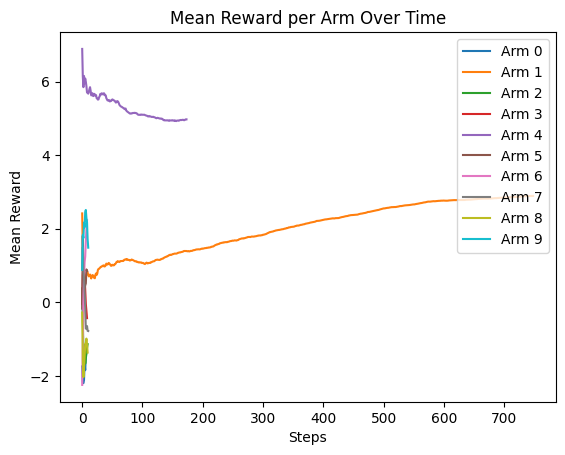

In [13]:
def plot_mean_reward_per_arm(rewards, chosen_arms, n_arms):
    arm_rewards = [[] for _ in range(n_arms)]
    for i, arm in enumerate(chosen_arms):
        arm_rewards[arm].append(rewards[i])

    for arm in range(n_arms):
        mean_rewards = np.cumsum(arm_rewards[arm]) / (np.arange(len(arm_rewards[arm])) + 1)
        plt.plot(mean_rewards, label=f"Arm {arm}")

    plt.title("Mean Reward per Arm Over Time")
    plt.xlabel("Steps")
    plt.ylabel("Mean Reward")
    plt.legend()
    plt.show()

plot_mean_reward_per_arm(rewards, chosen_arms, n_arms)
